# Pneumonia Detection

### 1. Import Libraries

In [118]:
import os
# importing numpy and pandas to manipulate the data
import numpy as np
import pandas as pd
# matplotlib.pyplot for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

### 2. Loading and Exploring the Dataset

In [ ]:
os.listdir('C:/Users/aleja/OneDrive/Desktop/chest_xray/')

['chest_xray', 'test', 'train', 'val']

In [ ]:
# checking number of images
len(os.listdir('C:/Users/aleja/OneDrive/Desktop/chest_xray/train/PNEUMONIA'))

3875

In [ ]:
len(os.listdir('C:/Users/aleja/OneDrive/Desktop/chest_xray/train/NORMAL'))

1341

In [ ]:
# defining the paths for the training, testing and validation datasets
train_dir = "C:/Users/aleja/OneDrive/Desktop/chest_xray/train"
test_dir = "C:/Users/aleja/OneDrive/Desktop/chest_xray/test"
val_dir = "C:/Users/aleja/OneDrive/Desktop/chest_xray/val"

### 3. Counting Images in Each Set

In [123]:
print("----------\nTrain set:\n----------")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA = {num_pneumonia}")
print(f"NORMAL = {num_normal}")

print("----------\nTest Set:\n----------")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("----------\nValidation Set:\n----------")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

----------
Train set:
----------
PNEUMONIA = 3875
NORMAL = 1341
----------
Test Set:
----------
PNEUMONIA = 390
NORMAL = 234
----------
Validation Set:
----------
PNEUMONIA = 8
NORMAL = 8


### 4. Visualize Sample Images

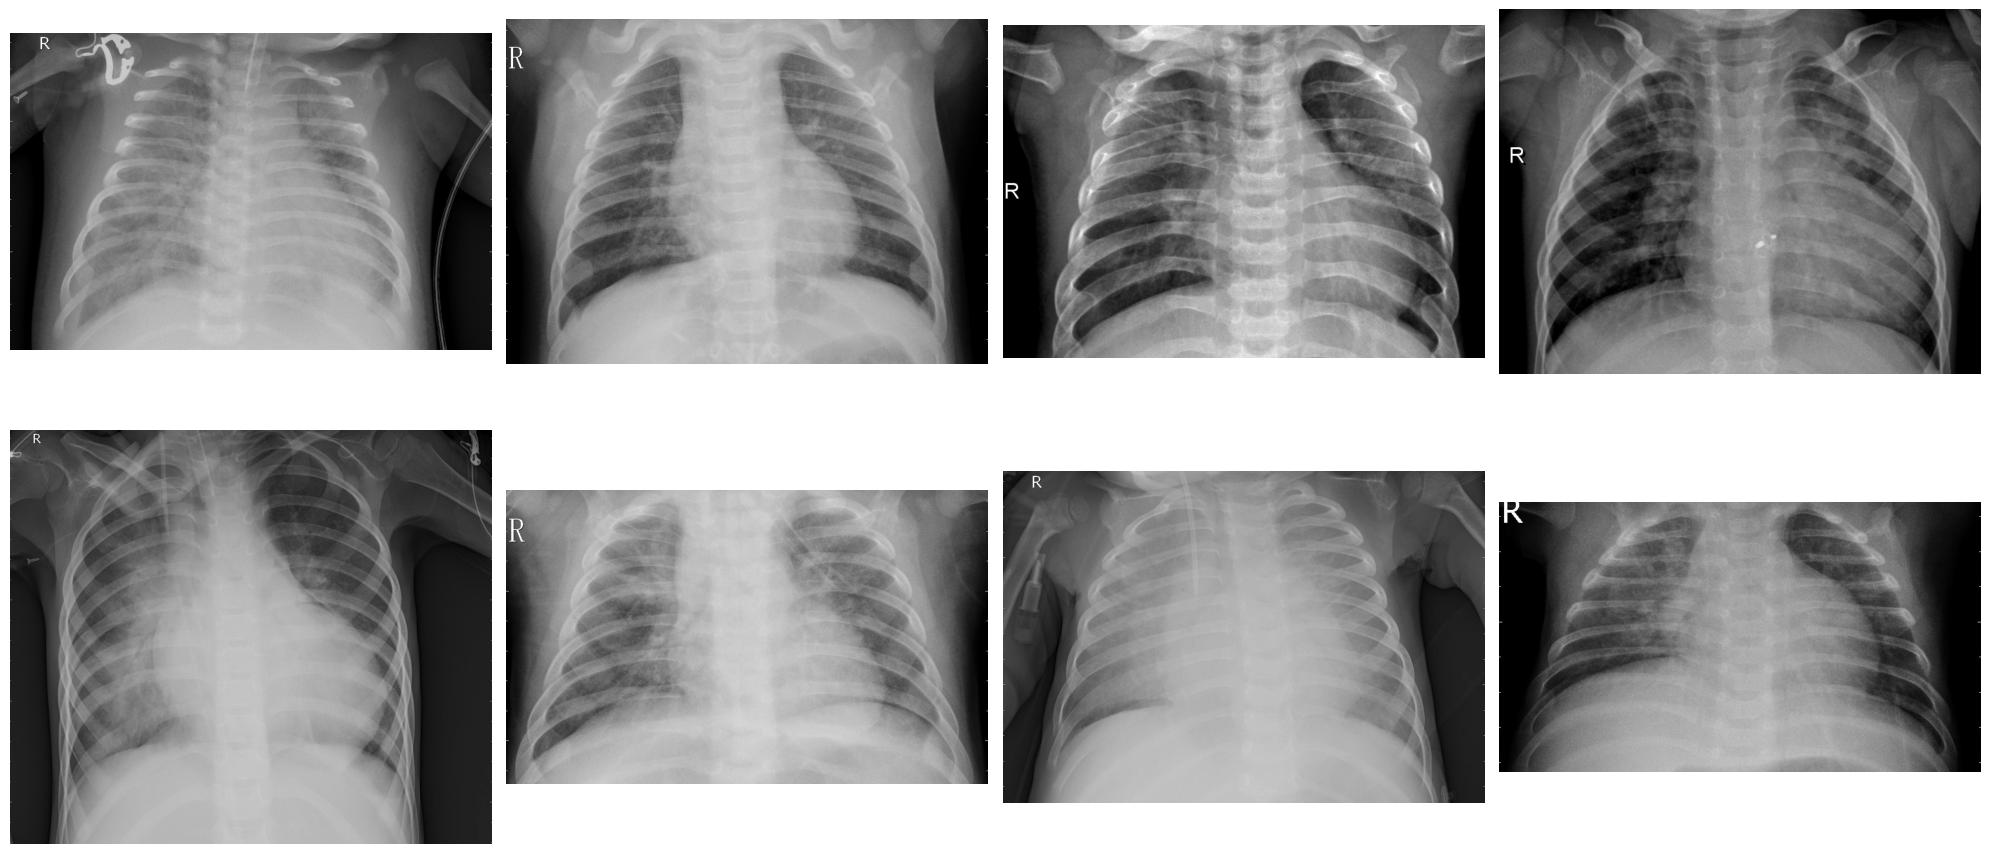

In [ ]:
pneumonia = os.listdir("C:/Users/aleja/OneDrive/Desktop/chest_xray/train/PNEUMONIA")
pneumonia_dir = "C:/Users/aleja/OneDrive/Desktop/chest_xray/train/PNEUMONIA"

# visualize sample pneumonia images
plt.figure(figsize=(20, 10))

for i in range(8):
    plt.subplot(2, 4, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

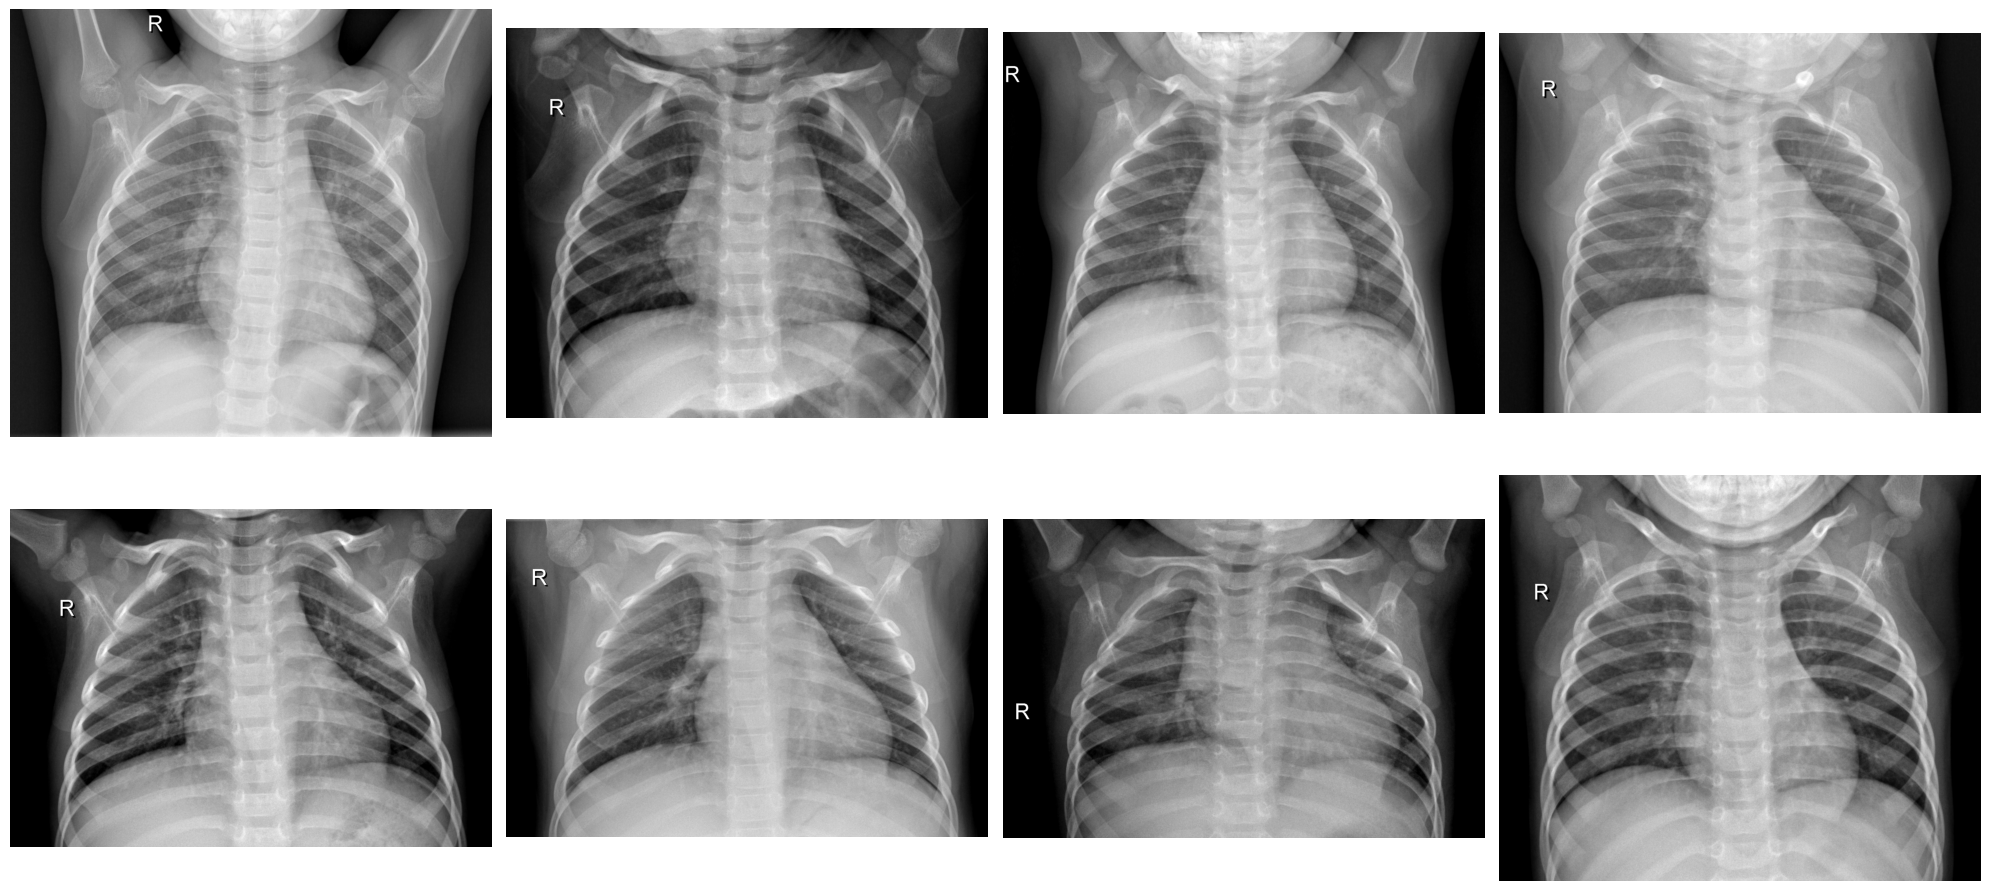

In [ ]:
normal = os.listdir("C:/Users/aleja/OneDrive/Desktop/chest_xray/train/NORMAL")
normal_dir = "C:/Users/aleja/OneDrive/Desktop/chest_xray/train/NORMAL"

# visualize sample normal images
plt.figure(figsize=(20, 10))

for i in range(8):
    plt.subplot(2, 4, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

### 5. Image Preprocessing

In [126]:
# to prepare images to suitably perform when training a CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range = 20, # randomly rotate the images within 20 degrees
    width_shift_range = 0.1, # shifts the image by upto 10 percent of the width
    shear_range = 0.1,
    zoom_range = 0.1, # zoom in or out by upto 10 percent
    samplewise_center = True,
    samplewise_std_normalization = True
)

### 6. Loading Training, Validation, and Test Data

In [136]:
# building a generator for train, validation, and test images
# flow_from_directory automatically seperates the images and their labels
# based on the folder structure
train = image_generator.flow_from_directory(train_dir,
                                            # the model processes 8 images at a time before updating the weights
                                            batch_size = 8,
                                            # shuffle to prevent the model seeing the same order during every epoch
                                            shuffle = True,
                                            # either 'PNEUMONIA' or 'NORMAL'
                                            class_mode = 'binary',
                                            # resize images to 180*180 pixels
                                            target_size = (180, 180))

validation = image_generator.flow_from_directory(val_dir,
                                                 batch_size = 1,
                                                 shuffle = False,
                                                 class_mode = 'binary',
                                                 target_size = (180, 180))

test = image_generator.flow_from_directory(test_dir,
                                           batch_size = 1,
                                           # not shuffle to preserve order for evaluation
                                           shuffle = False,
                                           class_mode = 'binary',
                                           target_size = (180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [128]:
# rechecking the mapping between class labels and folder names
print(train.class_indices)
print(test.class_indices)
print(validation.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


### 7. Balancing Classes with Class Weights

In [160]:
# Class weights, to solve the issue of class imbalance which
# gives more importance to undderepresented class ('normal') during model training
# so the model doesn't become biased toward the majority class

weight_for_0 = num_normal / (num_normal + num_pneumonia)
weight_for_1 = num_pneumonia / (num_normal + num_pneumonia)

class_weight = {0: weight_for_1, 1: weight_for_0}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.26
Weight for class 1: 0.74


### 8. Building the custom CNN Model

In [161]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

In [165]:
model = Sequential()

# 1st convolutional block: with 32 filters (learning 32 feature maps from the images)
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
# normalize the output from the convolutional layers to make sure that
# each layer's input has zero mean and unit variance
model.add(BatchNormalization())
# 2nd convolutional layer in the 1st block to further refining the learned features from the 1st layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
# reduces the spatial size of the feature maps by applying a max pooling operation
# with a pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))

# 2nd convolutional block
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 3rd convolutional block
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# dropout some neurons to prevent overfitting
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

# model compilation
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [163]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 176, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 84, 84, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 38, 38, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │     5,914,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,203,681 (23.67 MB)

 Trainable params: 6,202,785 (23.66 MB)

 Non-trainable params: 896 (3.50 KB)

### 9. Training the Model (Mdel r1)

In [166]:
r1 = model.fit(
    train, 
    epochs=100,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7388 - loss: 3.2435 - val_accuracy: 0.5000 - val_loss: 6.1058
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.8446 - loss: 0.1538 - val_accuracy: 0.5000 - val_loss: 9.9909
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.8217 - loss: 0.1460 - val_accuracy: 0.5625 - val_loss: 1.2467
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.8952 - loss: 0.1214 - val_accuracy: 0.5625 - val_loss: 1.6017
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.8979 - loss: 0.0956 - val_accuracy: 0.5625 - val_loss: 3.3734
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.8722 - loss: 0.1004 - val_accuracy: 0.5000 - val_loss: 3.3425
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.8577 - loss: 0.1578 - val_accuracy: 0.6250 - val_loss: 2.1897
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step - accuracy: 0.8555 -

### 10. Plotting Loss and Accuracy

Text(0.5, 1.0, 'Accuracy Over Epoch (Model r1)')

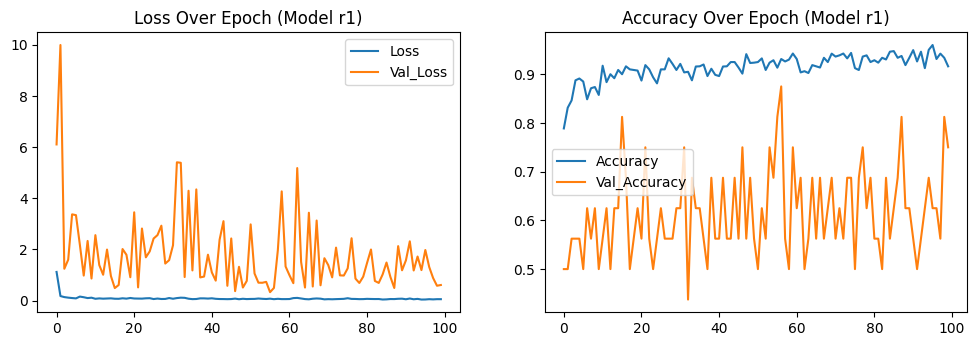

In [167]:
# visualize the training loss and validation loss over time,
# to check if the model is overfitting or underfitting
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r1.history['loss'], label='Loss')
plt.plot(r1.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Over Epoch (Model r1)')

plt.subplot(2, 2, 2)
plt.plot(r1.history['accuracy'], label='Accuracy')
plt.plot(r1.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Over Epoch (Model r1)')

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r2.history['loss'], label='Loss')
plt.plot(r2.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Over Epoch (Model r2)')

plt.subplot(2, 2, 2)
plt.plot(r2.history['accuracy'], label='Accuracy')
plt.plot(r2.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Over Epoch (Model r2)')

### 11. Evaluating the Model

In [168]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8001 - loss: 0.6623
Test Accuracy: 86.38%
652/652 ━━━━━━━━━━━━━━━━━━━━ 71s 109ms/step - accuracy: 0.9520 - loss: 0.1162
Train Accuracy: 95.15%


### 12. Confusion Matrix and Classification Report

In [169]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
[[167  67]
 [ 13 377]]


,0,1,accuracy,macro avg,weighted avg
precision,0.927778,0.849099,0.871795,0.888438,0.878604
recall,0.713675,0.966667,0.871795,0.840171,0.871795
f1-score,0.806763,0.904077,0.871795,0.855420,0.867584
support,234.000000,390.000000,0.871795,624.000000,624.000000


### 13. Tuning Hyperparameters (Model r2)

In [241]:
train2 = image_generator.flow_from_directory(train_dir,
                                            # increasing batch size to 16
                                            batch_size = 16,
                                            shuffle = True,
                                            class_mode = 'binary',
                                            target_size = (180, 180))
validation2 = image_generator.flow_from_directory(val_dir,
                                                 batch_size = 1,
                                                 shuffle = False,
                                                 class_mode = 'binary',
                                                 target_size = (180, 180))
test2 = image_generator.flow_from_directory(test_dir,
                                           batch_size = 1,
                                           shuffle = False,
                                           class_mode = 'binary',
                                           target_size = (180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [242]:
model2 = Sequential()

# 1st convolutional block
model2.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

# 2nd convolutional block
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

# 3rd convolutional block
model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Flatten())
# adjusting dense layer to 256 neurons
model2.add(Dense(256, activation='relu'))
# dropout neurons to 20% prevent overfitting
model2.add(Dropout(0.2))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [243]:
from tensorflow.keras.callbacks import EarlyStopping
# adding early stopping to avoid overfitting by monitoring the validation loss
early_stopping = EarlyStopping(monitor='val_loss',
                               # if the validation loss doesn't improve 
                               # for 5 consecutive epochs, the training will stop
                               patience=5,
                               # restore where validation loss was the best 
                               restore_best_weights=True)

In [244]:
r2 = model2.fit(
    train2, 
    epochs=50,
    validation_data=validation2, 
    class_weight=class_weight,
    # updated steps so the model uses 120*16 = 1,920 images per epoch
    steps_per_epoch=120,
    validation_steps=25,
    callbacks=[early_stopping]
)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 66s 499ms/step - accuracy: 0.7284 - loss: 2.6820 - val_accuracy: 0.5000 - val_loss: 6.7238
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 58s 487ms/step - accuracy: 0.8682 - loss: 0.1540 - val_accuracy: 0.5000 - val_loss: 16.5074
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 345ms/step - accuracy: 0.8865 - loss: 0.1194 - val_accuracy: 0.5000 - val_loss: 13.7070
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 61s 495ms/step - accuracy: 0.8844 - loss: 0.1698 - val_accuracy: 0.5625 - val_loss: 2.6671
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 59s 491ms/step - accuracy: 0.9154 - loss: 0.0821 - val_accuracy: 0.5625 - val_loss: 4.8261
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 339ms/step - accuracy: 0.9173 - loss: 0.1068 - val_accuracy: 0.6250 - val_loss: 8.0065
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 479ms/step - accuracy: 0.9130 - loss: 0.0745 - val_accuracy: 0.5000 - val_loss: 4.0415
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 476ms/step - accuracy: 0.9157 - loss:

Text(0.5, 1.0, 'Accuracy Over Epoch (Model r2)')

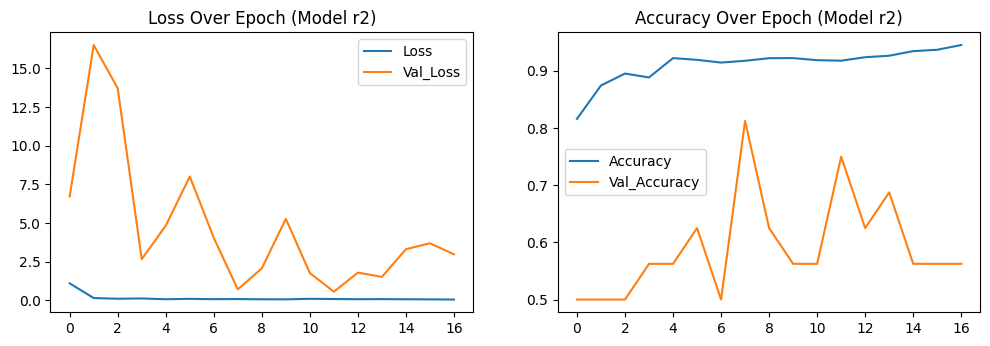

In [245]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r2.history['loss'], label='Loss')
plt.plot(r2.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Over Epoch (Model r2)')

plt.subplot(2, 2, 2)
plt.plot(r2.history['accuracy'], label='Accuracy')
plt.plot(r2.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Over Epoch (Model r2)')


In [256]:
evaluation = model2.evaluate(test2)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")
evaluation = model2.evaluate(train2)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8829 - loss: 0.3335
Test Accuracy: 89.42%
326/326 ━━━━━━━━━━━━━━━━━━━━ 90s 276ms/step - accuracy: 0.9116 - loss: 0.2527
Train Accuracy: 91.70%


In [325]:
pred = model2.predict(test2)

print(confusion_matrix(test2.classes, pred > 0.5))
pd.DataFrame(classification_report(test2.classes, pred > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
[[202  32]
 [ 30 360]]


,0,1,accuracy,macro avg,weighted avg
precision,0.870690,0.918367,0.900641,0.894529,0.900488
recall,0.863248,0.923077,0.900641,0.893162,0.900641
f1-score,0.866953,0.920716,0.900641,0.893834,0.900555
support,234.000000,390.000000,0.900641,624.000000,624.000000


### 14. Using Pre-Trained Model (VGG16)

In [384]:
image_generator2 = ImageDataGenerator(
    rotation_range = 10, # randomly rotate the images within 10 degrees
    width_shift_range = 0.1, # shifts the image by upto 10 percent of the width
    shear_range = 0.1,
    zoom_range = 0.1, # zoom in or out by upto 10 percent
    samplewise_center = True,
    samplewise_std_normalization = True
)

In [393]:
# modifying the images to match input size for VGG16 (224*224)
train3 = image_generator2.flow_from_directory(train_dir,
                                            # increase batch size to 32
                                            batch_size = 32,
                                            shuffle = True,
                                            class_mode = 'binary',
                                            # resize images to 224*224 pixels
                                            target_size = (224, 224))

validation3 = image_generator2.flow_from_directory(val_dir,
                                                 batch_size = 1,
                                                 shuffle = False,
                                                 class_mode = 'binary',
                                                 target_size = (224, 224))

test3 = image_generator2.flow_from_directory(test_dir,
                                           batch_size = 1,
                                           shuffle = False,
                                           class_mode = 'binary',
                                           target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [394]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [395]:
# loading the VGG16 model with pre-trained weights from ImageNet, without top fully connected layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [396]:
# freezing the pre-trained layers, so they aren't updated during training
for layer in vgg.layers:
    layer.trainable = False

In [398]:
# building the model on top in the VGG16
model3 = Sequential([
    vgg,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),  # dropout layer to 40% to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model
model3.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

In [399]:
model3.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [400]:
early_stopping_r3 = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True)

r3 = model3.fit(
    train3, # using prepared images (224*224)
    epochs=50,
    validation_data=validation3,
    class_weight=class_weight,
    steps_per_epoch=110,
    validation_steps=25,
    callbacks=[early_stopping_r3]
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.8660 - loss: 0.1105 - val_accuracy: 0.8750 - val_loss: 0.2177
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 937ms/step - accuracy: 0.9375 - loss: 0.0551 - val_accuracy: 1.0000 - val_loss: 0.0731
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9615 - loss: 0.0365 - val_accuracy: 0.7500 - val_loss: 0.4862
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 959ms/step - accuracy: 0.9538 - loss: 0.0448 - val_accuracy: 0.9375 - val_loss: 0.1820
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9597 - loss: 0.0387 - val_accuracy: 1.0000 - val_loss: 0.0559
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 97s 968ms/step - accuracy: 0.9706 - loss: 0.0292 - val_accuracy: 1.0000 - val_loss: 0.0569
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9653 - loss: 0.0327 - val_accuracy: 0.8750 - val_loss: 0.1786
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 97s 965ms/step - accuracy: 0.9703 - loss: 0.0304 - 

Text(0.5, 1.0, 'Accuracy Over Epoch (Model r3(VGG16))')

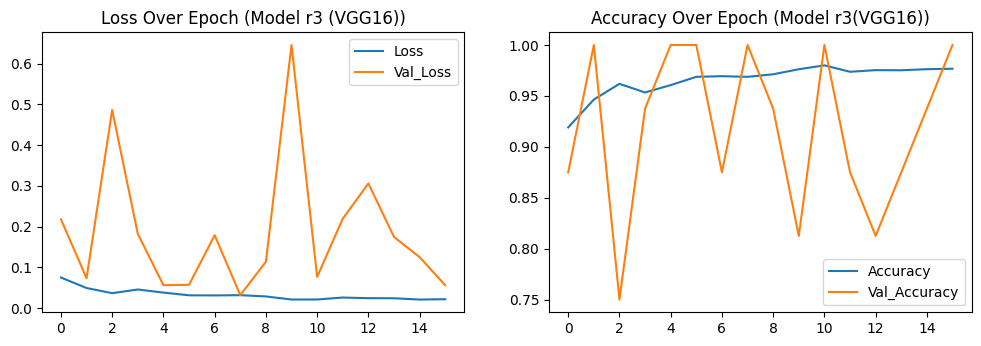

In [401]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r3.history['loss'], label='Loss')
plt.plot(r3.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Over Epoch (Model r3 (VGG16))')

plt.subplot(2, 2, 2)
plt.plot(r3.history['accuracy'], label='Accuracy')
plt.plot(r3.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Over Epoch (Model r3(VGG16))')

In [457]:
evaluation = model3.evaluate(test3)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model3.evaluate(train3)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8838 - loss: 0.3704
Test Accuracy: 91.83%
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9538 - loss: 0.1226
Train Accuracy: 95.30%


In [427]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model3.predict(test3)

print(confusion_matrix(test3.classes, pred > 0.5))
pd.DataFrame(classification_report(test3.classes, pred > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step
[[193  41]
 [  7 383]]


,0,1,accuracy,macro avg,weighted avg
precision,0.965000,0.903302,0.923077,0.934151,0.926439
recall,0.824786,0.982051,0.923077,0.903419,0.923077
f1-score,0.889401,0.941032,0.923077,0.915216,0.921670
support,234.000000,390.000000,0.923077,624.000000,624.000000
